In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [30]:
# Dataset location
train_csv = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/train.csv"
test_csv = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/test.csv"
train_dir = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/train_images/"
test_dir = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/test_images/"
prep_train_dir = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/train_prep_images/"
prep_test_dir = "/home/resl/Dev/Datasets/APTOS-2019-Blindness-Detection-Dataset/test_prep_images/"

use_preprocessed = True
dump_preprocessed = True

if use_preprocessed and os.path.isdir(prep_train_dir) and os.path.isdir(prep_test_dir):
    print("Using preprocessed images")
    train_dir = prep_train_dir
    test_dir = prep_test_dir
    dump_preprocessed = False
else:
    if not os.path.isdir(prep_train_dir):
        os.mkdir(prep_train_dir)
    if not os.path.isdir(prep_test_dir):
        os.mkdir(prep_test_dir)

Using preprocessed images


Training Size:  3662
Testing Size:  1928


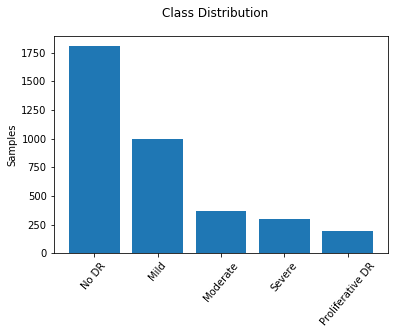

In [31]:
# Dataset Analysis

train_data = pd.read_csv(train_csv)
test_data = pd.read_csv(test_csv)
class_labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

print("Training Size: ", len(train_data))
print("Testing Size: ", len(test_data))

plt.suptitle("Class Distribution")
plt.bar(range(5), train_data.diagnosis.value_counts())
plt.xticks(range(5), class_labels, rotation=50)
plt.ylabel("Samples")
plt.show()

In [38]:
# Some Visualizations
%matplotlib
im_shape = (128, 128, 3)

def load_image(path, dim=None):
    im = Image.open(path)
    if dim is not None:
        im = im.resize(dim,resample=Image.LANCZOS)
    return im

num_classes = len(class_labels)
num_samples = 5
figure = plt.figure()

for i, label in enumerate(class_labels):
    samples = train_data.loc[train_data.diagnosis==i, 'id_code'].sample(num_samples,).reset_index(drop=True)
    for j in range(num_samples):
        im = load_image(train_dir + str(samples[j]) + ".png", (im_shape[0], im_shape[1]))
        fig_ax = figure.add_subplot(num_classes, num_classes, i+5*j+1)
        fig_ax.set_xticks([], [])
        fig_ax.set_yticks([], [])
        if j==0:
            fig_ax.set_title(class_labels[i])
        fig_ax.imshow(im)
        
plt.show()

Using matplotlib backend: Qt5Agg


In [56]:
images = np.empty(shape=(len(train_data.index), im_shape[0], im_shape[1], 3))
labels = np.empty(shape=(len(train_data.index),))
for i, row in tqdm(train_data.iterrows()):
    im = load_image(train_dir + str(row.id_code) + ".png", (im_shape[0], im_shape[1]))
    images[i] = np.array(im)
    labels[i] = row.diagnosis
    if dump_preprocessed:
        im.save(prep_train_dir + str(row.id_code) + ".png")

validation_images = images[:int(len(images)*0.2)]
validation_labels = labels[:int(len(images)*0.2)]
train_images = images[int(len(images)*0.2):]
train_labels = labels[int(len(images)*0.2):]
del(images)

print(train_images.shape, train_labels.shape)
print(validation_images.shape, validation_labels.shape)

# Time (original+saving preprocessed) : 6 min
# Time (preprocessed): 2 s (Awesome!!)

3662it [00:02, 1412.44it/s]

(2930, 128, 128, 3) (2930,)
(732, 128, 128, 3) (732,)


In [57]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [58]:
model.fit(train_images, train_labels, epochs=20)

Epoch 1/20
2930/2930 [==============================] - 2s 606us/sample - loss: 812.5951 - acc: 0.5904
Epoch 2/20
2930/2930 [==============================] - 2s 536us/sample - loss: 356.2006 - acc: 0.6273
Epoch 3/20
2930/2930 [==============================] - 2s 535us/sample - loss: 309.7778 - acc: 0.6307
Epoch 4/20
2930/2930 [==============================] - 2s 540us/sample - loss: 478.7250 - acc: 0.6140
Epoch 5/20
2930/2930 [==============================] - 2s 534us/sample - loss: 234.3044 - acc: 0.6642
Epoch 6/20
2930/2930 [==============================] - 2s 545us/sample - loss: 211.1136 - acc: 0.6529
Epoch 7/20
2930/2930 [==============================] - 2s 545us/sample - loss: 174.5321 - acc: 0.6570
Epoch 8/20
2930/2930 [==============================] - 2s 544us/sample - loss: 129.4324 - acc: 0.6655
Epoch 9/20
2930/2930 [==============================] - 2s 541us/sample - loss: 114.0969 - acc: 0.6765
Epoch 10/20
2930/2930 [==============================] - 2s 551us/sample 

In [21]:
model.evaluate(validation_images, validation_labels)

732/732 [==============================] - 0s 229us/sample - loss: 166.1225 - acc: 0.7199


[166.12251940451034, 0.7199454]

In [28]:
# test
images = np.empty(shape=(len(test_data.index), im_shape[0], im_shape[1], 3))
for i, row in tqdm(test_data.iterrows()):
    im = load_image(test_dir + str(row.id_code) + ".png", (im_shape[0], im_shape[1]))
    images[i] = np.array(im)
    if dump_preprocessed:
        im.save(prep_test_dir + str(row.id_code) + ".png")
    
test_images = images
# Time:
# Original + Dumping: 1 min
# Preprocessed: 1 s

1928it [00:01, 1349.36it/s]


In [65]:
predictions = model.predict(test_images)

In [107]:
# create submission
test_data.reset_index()
with open("submissions.csv", "w") as f:
    f.write("id_code, diagnosis\n")
    for i in range(len(predictions)):
        f.write(test_data.id_code[i] + "," + str(np.argmax(predictions[i])) + "\n")

In [103]:
test_data.id_code[0]

'0005cfc8afb6'

In [23]:
model.save("basic.h5")

In [ ]:
newmodel = tf